In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !gdown --id 1PwV2G9nrQ9AA5uWqMj2s9ZUeWQVuVEaf
# !gdown --id 1--bWJ07UHXnO0F-DMiKBgh7zg-sysBe-

In [ ]:
# !wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=myusername&password=mypassword&submit=Login' https://www.cityscapes-dataset.com/login/
# !wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1
# !wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3

In [ ]:
%%bash

unzip /content/drive/MyDrive/CS_project/CS406/Cityscapes_dataset/gtFine_trainvaltest.zip > cc.txt
rm -f cc.txt
rm -f README
rm -f license.txt

unzip /content/drive/MyDrive/CS_project/CS406/Cityscapes_dataset/leftImg8bit_trainvaltest.zip > cc.txt
rm -f cc.txt
rm -f README
rm -f license.txt

# Requirements

In [2]:
import os
from os import path
# os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import random
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import  Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout, Reshape, Permute
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
import tqdm as tqdm
import cv2
import cv2 as cv
import time
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip, ImageSequenceClip

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2154496/45929032 bytes (4.7%)5799936/45929032 bytes (12.6%)9535488/45929032 bytes (20.8%)12935168/45929032 bytes (28.2%)16760832/45929032 bytes (36.5%)20332544/45929032 bytes (44.3%)24027136/45929032 bytes (52.3%)27557888/45929032 bytes (60.0%)31277056/45929032 bytes (68.1%)34873344/45929032 bytes (75.9%)38404096/45929032 bytes (83.6%)42139648/45929032 bytes (91.7%)

# Losses

In [3]:
def dice_coeff(y_true, y_pred):
  smooth = 1.
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  dice_score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  return dice_score

def IoU_coeff(y_true, y_pred):
  smooth = 1.
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  iou_score = (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
  return iou_score

def dice_loss(y_true, y_pred):
  loss = 1 - dice_coeff(y_true, y_pred)
  return loss

def total_loss(y_true, y_pred):
  loss = categorical_crossentropy(y_true, y_pred) + (3*dice_loss(y_true, y_pred))
  return loss

# Define U-Net model

In [ ]:
def unet(num_classes, input_shape, lr_init, vgg_weight_path=None):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for_pretrained_weight = MaxPooling2D()(x)

    # Load pretrained weights.
    if vgg_weight_path is not None:
        vgg16 = Model(img_input, for_pretrained_weight)
        vgg16.load_weights(vgg_weight_path, by_name=True)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # last conv
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(lr=lr_init),
                  loss= [total_loss], metrics=[dice_coeff, IoU_coeff, 'accuracy'])
    return model

# Data

In [ ]:
# img_height, img_width = 256, 512
# cats = {'void': [0, 1, 2, 3, 4, 5, 6],
#  'flat': [7, 8, 9, 10],
#  'construction': [11, 12, 13, 14, 15, 16],
#  'object': [17, 18, 19, 20],
#  'nature': [21, 22],
#  'sky': [23],
#  'human': [24, 25],
#  'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

In [ ]:
# Use only 3 classes.
labels = ['background', 'person', 'car', 'road']

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
def pre_processing(img):
    # Random exposure and saturation (0.9 ~ 1.1 scale)
    rand_s = random.uniform(0.9, 1.1)
    rand_v = random.uniform(0.9, 1.1)

    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    tmp = np.ones_like(img[:, :, 1]) * 255
    img[:, :, 1] = np.where(img[:, :, 1] * rand_s > 255, tmp, img[:, :, 1] * rand_s)
    img[:, :, 2] = np.where(img[:, :, 2] * rand_v > 255, tmp, img[:, :, 2] * rand_v)

    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

    # Centering helps normalization image (-1 ~ 1 value)
    return img / 127.5 - 1

def get_data_gen_args(mode):
    if mode == 'train' or mode == 'val':
        x_data_gen_args = dict(preprocessing_function=pre_processing,
                               shear_range=0.1,
                               zoom_range=0.1,
                               rotation_range=10,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               fill_mode='constant',
                               horizontal_flip=True)

        y_data_gen_args = dict(shear_range=0.1,
                               zoom_range=0.1,
                               rotation_range=10,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               fill_mode='constant',
                               horizontal_flip=True)

    elif mode == 'test':
        x_data_gen_args = dict(preprocessing_function=pre_processing)
        y_data_gen_args = dict()

    else:
        print("Data_generator function should get mode arg 'train' or 'val' or 'test'.")
        return -1

    return x_data_gen_args, y_data_gen_args

# One hot encoding for y_img.
def get_result_map(b_size, y_img):
    y_img = np.squeeze(y_img, axis=3)
    result_map = np.zeros((b_size, 256, 512, 4))

    # For np.where calculation.
    person = (y_img == 24)
    person1 = (y_img == 25)
    person = np.logical_or(person, person1)

    car = (y_img == 26)
    car1 = (y_img == 27)
    car2 = (y_img == 28)
    car3 = (y_img == 29)
    car4 = (y_img == 30)
    car5 = (y_img == 31)
    car6 = (y_img == 32)
    car7 = (y_img == 33)
    car8 = (y_img == -1)
    
    car = np.logical_or(car , car1)
    car = np.logical_or(car , car2)
    car = np.logical_or(car , car3)
    car = np.logical_or(car , car4)
    car = np.logical_or(car , car5)
    car = np.logical_or(car , car6)
    car = np.logical_or(car , car7)
    car = np.logical_or(car , car8)

    road = (y_img == 7)

    background = np.logical_not(person + car + road)

    result_map[:, :, :, 0] = np.where(background, 1, 0)
    result_map[:, :, :, 1] = np.where(person, 1, 0)
    result_map[:, :, :, 2] = np.where(car, 1, 0)
    result_map[:, :, :, 3] = np.where(road, 1, 0)

    return result_map

# Data generator for fit_generator.
def data_generator(dataset, b_size, mode):

    x_imgs = dataset[0]
    y_imgs = dataset[1]

    # Make ImageDataGenerator.
    x_data_gen_args, y_data_gen_args = get_data_gen_args(mode)
    x_data_gen = ImageDataGenerator(**x_data_gen_args)
    y_data_gen = ImageDataGenerator(**y_data_gen_args)

    # random index for random data access.
    d_size = x_imgs.shape[0]
    shuffled_idx = list(range(d_size))

    x = []
    y = []
    while True:
        random.shuffle(shuffled_idx)
        for i in range(d_size):
            idx = shuffled_idx[i]

            x.append(x_imgs[idx].reshape((256, 512, 3)))
            y.append(y_imgs[idx].reshape((256, 512, 1)))

            if len(x) == b_size:
                # Adapt ImageDataGenerator flow method for data augmentation.
                _ = np.zeros(b_size)
                seed = random.randrange(1, 1000)

                x_tmp_gen = x_data_gen.flow(np.array(x), _,
                                            batch_size=b_size,
                                            seed=seed)
                y_tmp_gen = y_data_gen.flow(np.array(y), _,
                                            batch_size=b_size,
                                            seed=seed)

                # Finally, yield x, y data.
                x_result, _ = next(x_tmp_gen)
                y_result, _ = next(y_tmp_gen)

                yield x_result, get_result_map(b_size, y_result)

                x.clear()
                y.clear()

def load_data(lst_path_x, lst_path_y):
    images = []
    labels = []
    # i = 0
    # l = len(lst_path_x)
    for x,y in tqdm.tqdm(zip(lst_path_x, lst_path_y)):
        images.append(cv2.cvtColor(cv.resize(cv.imread(x),(512,256)), cv2.COLOR_BGR2RGB))

        y_img = cv.resize(cv.imread(y),(512,256))
        y_img = y_img[:, :, 0]
        labels.append(y_img)
        
    return np.asarray(images),np.asarray(labels)

# Train

In [ ]:
!nvidia-smi

Thu Jan  6 01:35:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load dataset Cityscapes

In [ ]:
# /content/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png
# /content/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png

In [ ]:
lst_image_train_path = []
lst_mask_train_path = []

lst_image_val_path = []
lst_mask_val_path = []

lst_image_test_path = []
lst_mask_test_path = []

for f in os.listdir("/content/leftImg8bit/train/"):
  lst_image_train_path.append("/content/leftImg8bit/train/"+f+"/")
for f in os.listdir("/content/gtFine/train/"):
  lst_mask_train_path.append("/content/gtFine/train/"+f+"/") 

for f in os.listdir("/content/leftImg8bit/val/"):
  lst_image_val_path.append("/content/leftImg8bit/val/"+f+"/") 
for f in os.listdir("/content/gtFine/val/"):
  lst_mask_val_path.append("/content/gtFine/val/"+f+"/") 
  
for f in os.listdir("/content/leftImg8bit/test/"):
  lst_image_test_path.append("/content/leftImg8bit/test/"+f+"/") 
for f in os.listdir("/content/gtFine/test/"):
  lst_mask_test_path.append("/content/gtFine/test/"+f+"/")

lst_image_train_path = sorted(lst_image_train_path)
lst_mask_train_path = sorted(lst_mask_train_path)

lst_image_val_path = sorted(lst_image_val_path)
lst_mask_val_path = sorted(lst_mask_val_path)

lst_image_test_path = sorted(lst_image_test_path)
lst_mask_test_path = sorted(lst_mask_test_path)

### Train

In [ ]:
# Train
lst_train_x = []
lst_train_y = []

# load image path
for folder in lst_image_train_path:
  for img in os.listdir(folder):
    if os.path.isfile(folder+img):
      lst_train_x.append(folder+img)
# load mask path
for folder in lst_mask_train_path:
  for mask in os.listdir(folder):
    if os.path.isfile(folder+mask) and "_gtFine_labelIds.png" in mask:
      lst_train_y.append(folder+mask)

lst_train_x = sorted(lst_train_x)
lst_train_y = sorted(lst_train_y)

print(len(lst_train_x), len(lst_train_y))

2975 2975


In [ ]:
train_dataset = load_data(lst_train_x, lst_train_y)

2975it [04:03, 12.20it/s]


### Validation

In [ ]:
# Validation
lst_val_x = []
lst_val_y = []

# load image path
for folder in lst_image_val_path:
  for img in os.listdir(folder):
    if os.path.isfile(folder+img):
      lst_val_x.append(folder+img)
# load mask path
for folder in lst_mask_val_path:
  for mask in os.listdir(folder):
    if os.path.isfile(folder+mask) and "_gtFine_labelIds.png" in mask:
      lst_val_y.append(folder+mask)

lst_val_x = sorted(lst_val_x)
lst_val_y = sorted(lst_val_y)

print(len(lst_val_x), len(lst_val_y))

500 500


In [ ]:
val_dataset = load_data(lst_val_x, lst_val_y)

500it [00:38, 13.02it/s]


### Test

In [ ]:
# Test
lst_test_x = []
lst_test_y = []

# load image path
for folder in lst_image_test_path:
  for img in os.listdir(folder):
    if os.path.isfile(folder+img):
      lst_test_x.append(folder+img)
# load mask path
for folder in lst_mask_test_path:
  for mask in os.listdir(folder):
    if os.path.isfile(folder+mask) and "_gtFine_labelIds.png" in mask:
      lst_test_y.append(folder+mask)

lst_test_x = sorted(lst_test_x)
lst_test_y = sorted(lst_test_y)

print(len(lst_test_x), len(lst_test_y))

1525 1525


In [ ]:
test_dataset = load_data(lst_test_x, lst_test_y)

1525it [01:55, 13.16it/s]


## Visual example of dataset

<Figure size 720x720 with 0 Axes>

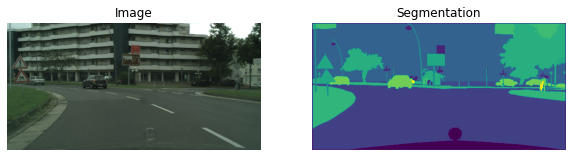

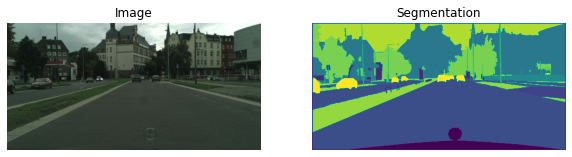

In [ ]:
import matplotlib.pyplot as plt

idx = 0
plt.figure(figsize=(10, 10))
for images, lables in zip(train_dataset[0],  train_dataset[1]):
    fig, arr = plt.subplots(1, 2 , figsize=(10, 10))
    arr[0].imshow(images)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(lables)
    arr[1].set_title('Segmentation')
    arr[1].axis("off") 
    idx +=1
    if idx ==2:
      break

## Load pretrained model VGG16 offered by keras.

In [ ]:
!gdown --id 152DjgAX7OzUYl1vnd94ofwOOxjpTg6-1

Downloading...
From: https://drive.google.com/uc?id=152DjgAX7OzUYl1vnd94ofwOOxjpTg6-1
To: /content/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
100% 58.9M/58.9M [00:00<00:00, 104MB/s] 


## Initialize parameter and callback

In [4]:
batch_size = 10 # Batch size for train.
val_batch = 10 # Batch size for validation.
lr_init = 1e-4 # Initial learning rate.
# lr_decay = 5e-4 # How much to decay the learning rate.
vgg_path = "/content/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5" # Pretrained vgg16 weight path.

# val_dice_coeff, val_IoU_coeff
callback = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=1e-1, patience=2, verbose=1, min_lr = 2e-6)
model_checkpoint = ModelCheckpoint('Cityscapes-unet-semantic-model.h5', monitor='val_loss',verbose=1, save_best_only=True)

In [5]:
# Use only 3 classes.
labels = ['background', 'person', 'car', 'road']

## Initialize model Unet with VGG 16 pretrained

In [ ]:
tf.keras.backend.clear_session()
model = unet(input_shape=(256, 512, 3), 
             num_classes=len(labels),
             lr_init=lr_init, 
             vgg_weight_path=vgg_path)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 512, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                           

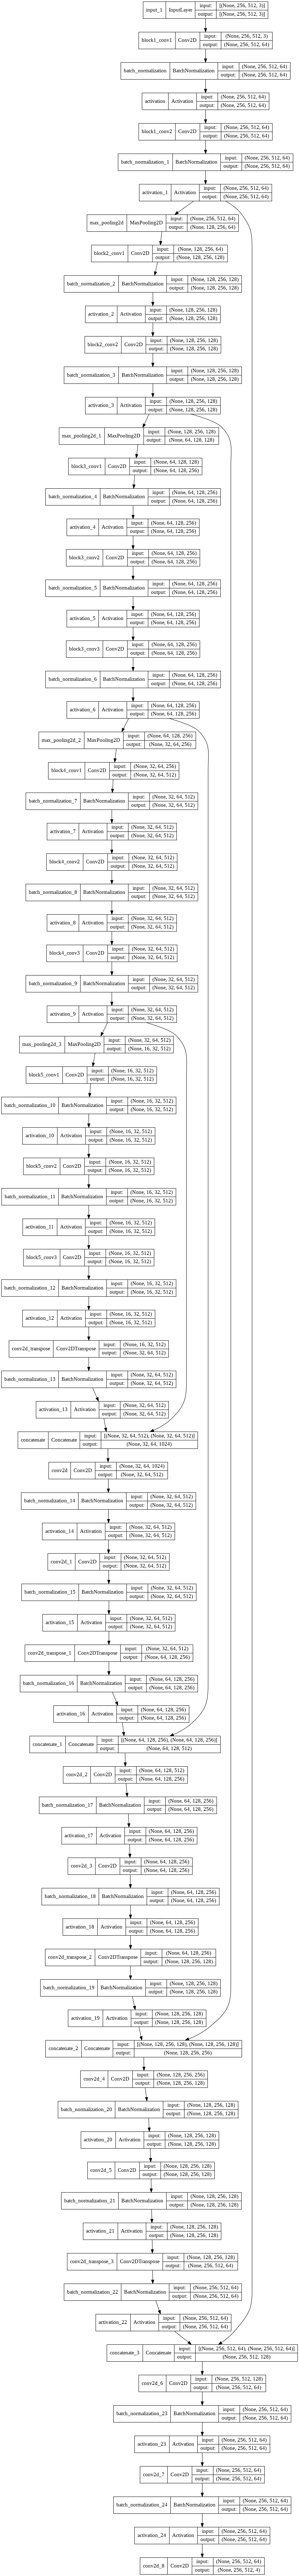

In [ ]:
tf.keras.utils.plot_model(model, show_shapes= True)

## Model training

In [ ]:
history = model.fit_generator(data_generator(train_dataset, batch_size, 'train'),
                              steps_per_epoch=len(train_dataset[0]) // batch_size,
                              validation_data=data_generator(val_dataset, val_batch, 'val'),
                              validation_steps=len(val_dataset[0]) // val_batch,
                              callbacks=[callback, reduce_lr, model_checkpoint],
                              epochs=100,
                              verbose=1)

Epoch 1/100
297/297 [==============================] - ETA: 0s - loss: 0.7766 - dice_coeff: 0.8519 - IoU_coeff: 0.7634 - accuracy: 0.8955
Epoch 00001: val_loss improved from inf to 0.45307, saving model to Cityscapes-unet-semantic-model.h5
297/297 [==============================] - 907s 3s/step - loss: 0.7766 - dice_coeff: 0.8519 - IoU_coeff: 0.7634 - accuracy: 0.8955 - val_loss: 0.4531 - val_dice_coeff: 0.9170 - val_IoU_coeff: 0.8471 - val_accuracy: 0.9364 - lr: 1.0000e-04
Epoch 2/100
297/297 [==============================] - ETA: 0s - loss: 0.3419 - dice_coeff: 0.9380 - IoU_coeff: 0.8836 - accuracy: 0.9500
Epoch 00002: val_loss did not improve from 0.45307
297/297 [==============================] - 876s 3s/step - loss: 0.3419 - dice_coeff: 0.9380 - IoU_coeff: 0.8836 - accuracy: 0.9500 - val_loss: 0.5536 - val_dice_coeff: 0.9144 - val_IoU_coeff: 0.8433 - val_accuracy: 0.9220 - lr: 1.0000e-04
Epoch 3/100
297/297 [==============================] - ETA: 0s - loss: 0.2856 - dice_coeff: 0

In [ ]:
model.save('/content/drive/MyDrive/CS_project/CS406/Cityscapes-unet-semantic-model.h5')

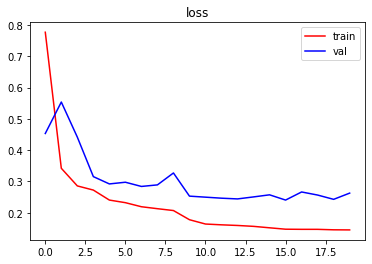

In [ ]:
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")
plt.savefig('Unet_loss.png')

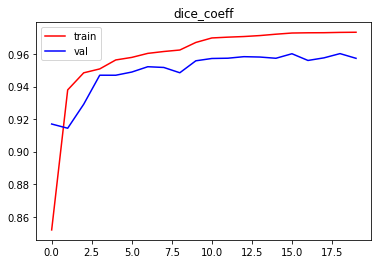

In [ ]:
plt.gcf().clear()
plt.title("dice_coeff")
plt.plot(history.history["dice_coeff"], color="r", label="train")
plt.plot(history.history["val_dice_coeff"], color="b", label="val")
plt.legend(loc="best")
plt.savefig('Unet_dice_coeff.png')

# Evaluate

## Test set

In [ ]:
highest_test = None
h_count = 0
lowest_test = None
l_count = 0

In [ ]:
#trung bình test set
result_of_test_set = model_loaded.evaluate(data_generator(test_dataset, 25, 'test'), steps = 61, callbacks=[callback, reduce_lr,model_checkpoint])

61/61 [==============================] - 141s 2s/step - loss: 4.5410 - dice_coeff: 0.5691 - IoU_coeff: 0.3980 - accuracy: 0.5688


In [ ]:
for i in tqdm.tqdm(range(len(test_dataset[0]))):
  X = np.asarray([test_dataset[0][i]])
  y= get_result_map(1, np.asarray([test_dataset[1][i].reshape((256, 512, 1))]))
  result = model_loaded.evaluate(X,y, steps = 1, callbacks=[callback, reduce_lr,model_checkpoint])
  if highest_test == None or highest_test[1:] < result[1:] and highest_test[0] >  result[0]:
    highest_test = result
    h_count = i
  if lowest_test == None or lowest_test[1:] > result[1:] and lowest_test[0] <  result[0]:
    lowest_test = result
    l_count = i

In [ ]:
#cao nhất
highest_test

[8.650247573852539, 0.656812846660614, 0.4889971911907196, 0.6579971313476562]

In [ ]:
h_count

845

In [ ]:
#thấp nhất
lowest_test

[67.68815612792969,
 0.18594738841056824,
 0.10250575095415115,
 0.18547821044921875]

In [ ]:
l_count

138

(-0.5, 511.5, 255.5, -0.5)

<Figure size 2160x2160 with 0 Axes>

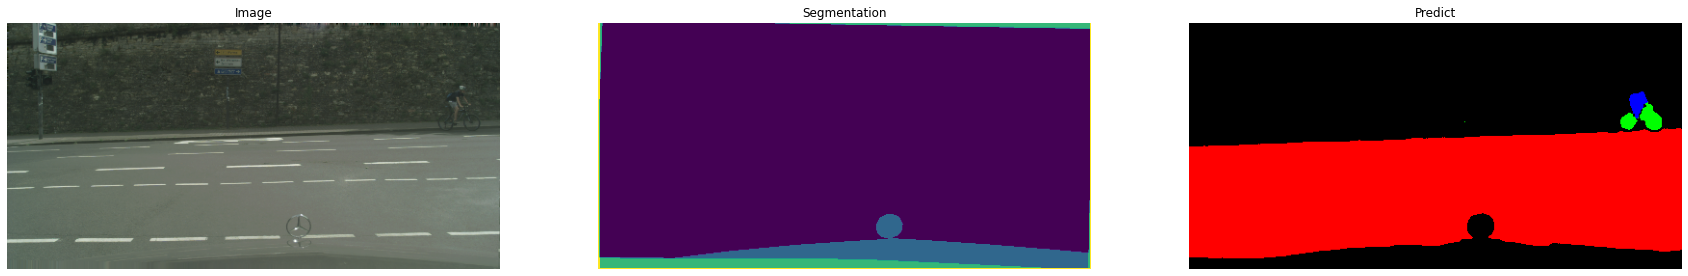

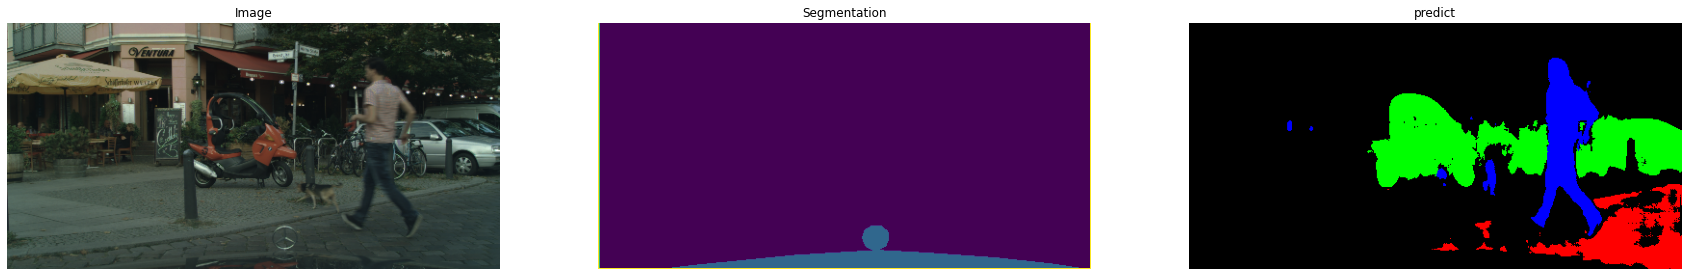

In [ ]:
#visual
img_highest = cv.imread(lst_test_x[845])
x_img = cv2.cvtColor(cv.resize(img_highest, (512,256)), cv2.COLOR_BGR2RGB)
x_img = x_img / 127.5 - 1
x_img = np.expand_dims(x_img, 0)
pred = model_loaded(x_img)[0]

plt.figure(figsize=(30, 30))

fig, arr = plt.subplots(1, 3 , figsize=(30, 10))
arr[0].imshow(test_dataset[0][845])
arr[0].set_title('Image')
arr[0].axis("off")
arr[1].imshow(test_dataset[1][845])
arr[1].set_title('Segmentation')
arr[1].axis("off") 
arr[2].imshow(cv2.cvtColor(result_map_to_img(pred), cv2.COLOR_BGR2RGB))
arr[2].set_title('Predict')
arr[2].axis("off") 


img_lowest = cv.imread(lst_test_x[138])
x_img = cv2.cvtColor(cv.resize(img_lowest, (512,256)), cv2.COLOR_BGR2RGB)
x_img = x_img / 127.5 - 1
x_img = np.expand_dims(x_img, 0)
pred = model_loaded(x_img)[0]

fig, arr = plt.subplots(1, 3 , figsize=(30, 10))
arr[0].imshow(test_dataset[0][138])
arr[0].set_title('Image')
arr[0].axis("off")
arr[1].imshow(test_dataset[1][138])
arr[1].set_title('Segmentation')
arr[1].axis("off") 
arr[2].imshow(cv2.cvtColor(result_map_to_img(pred), cv2.COLOR_BGR2RGB))
arr[2].set_title('predict')
arr[2].axis("off") 

## Validation set

In [ ]:
image_path = "/content/drive/MyDrive/CS_project/CS406/data_semantics/training/image_2/"
mask_path = "/content/drive/MyDrive/CS_project/CS406/data_semantics/training/semantic/"
  
lst_kitti_x = sorted([image_path + f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))])
lst_kitti_y = sorted([mask_path + f for f in os.listdir(mask_path) if os.path.isfile(os.path.join(mask_path, f))])

print(len(lst_kitti_x),len(lst_kitti_y))
kitti_dataset = load_data(lst_kitti_x, lst_kitti_y)

200 200


200it [00:06, 28.84it/s]


In [ ]:
highest_val = None
h_count = 0
lowest_val = None
l_count = 0

In [ ]:
#trung bình test set
result_of_val_set = model_loaded.evaluate(data_generator(kitti_dataset, 20, 'test'), steps = 200//20, callbacks=[callback, reduce_lr,model_checkpoint])

10/10 [==============================] - 34s 2s/step - loss: 0.3960 - dice_coeff: 0.9328 - IoU_coeff: 0.8742 - accuracy: 0.9418


In [ ]:
for i in tqdm.tqdm(range(len(kitti_dataset[0]))):
  X = np.asarray([kitti_dataset[0][i]])
  y = np.asarray([kitti_dataset[1][i]])
  # y= get_result_map(1, np.asarray([val_dataset[1][200].reshape((256, 512, 1))]))

  result = model_loaded.evaluate(data_generator((X,y),1,'test'), steps = 1, callbacks=[callback, reduce_lr,model_checkpoint])
  if highest_val == None or highest_val[1:] < result[1:]:
    highest_val = result
    h_count = i
  if lowest_val == None or lowest_val[1:] > result[1:]:
    lowest_val = result
    l_count = i

In [ ]:
#cao nhất
print(h_count)
highest_val

128


[0.05541941896080971,
 0.988993763923645,
 0.9782271385192871,
 0.9932479858398438]

In [ ]:
#thấp nhất
print(l_count)
lowest_val

169


[1.666377067565918, 0.7215317487716675, 0.5643733143806458, 0.732086181640625]

(-0.5, 511.5, 255.5, -0.5)

<Figure size 2160x2160 with 0 Axes>

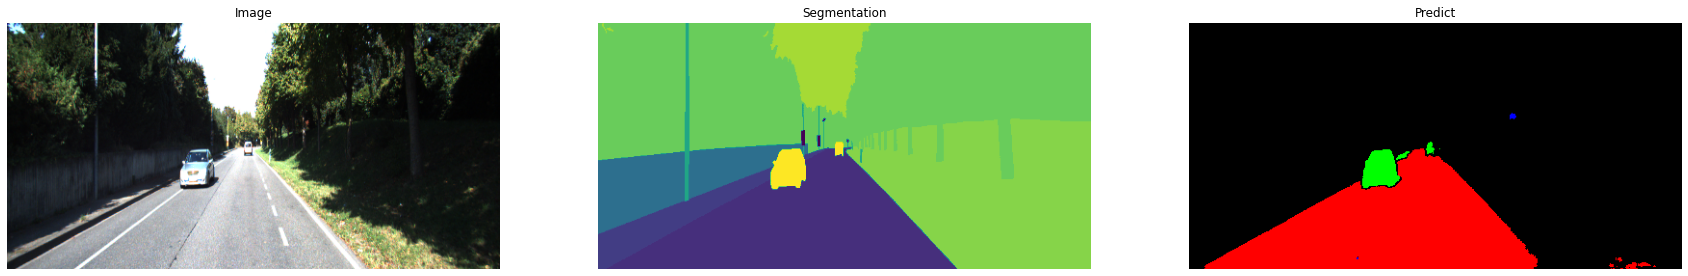

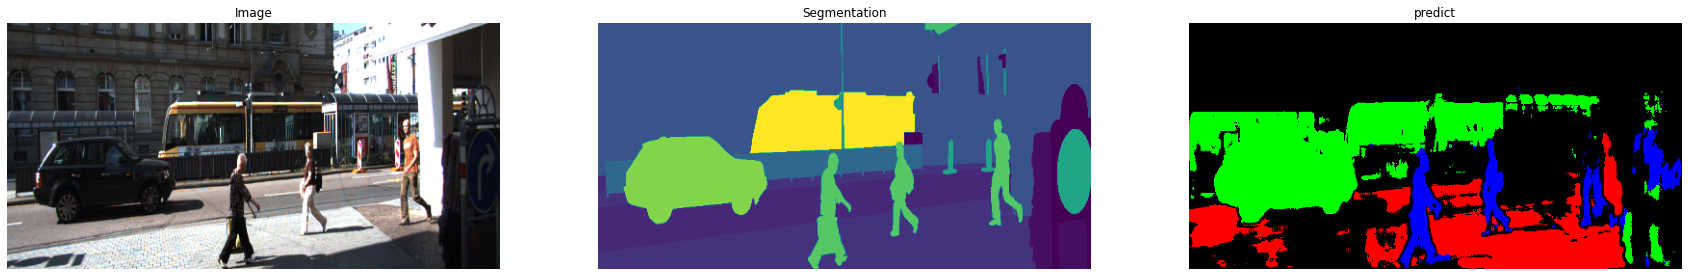

In [ ]:
#visual
img_highest = cv.imread(lst_kitti_x[h_count])
x_img = cv2.cvtColor(cv.resize(img_highest, (512,256)), cv2.COLOR_BGR2RGB)
x_img = x_img / 127.5 - 1
x_img = np.expand_dims(x_img, 0)
pred = model_loaded(x_img)[0]

plt.figure(figsize=(30, 30))

fig, arr = plt.subplots(1, 3 , figsize=(30, 10))
arr[0].imshow(kitti_dataset[0][h_count])
arr[0].set_title('Image')
arr[0].axis("off")
arr[1].imshow(kitti_dataset[1][h_count])
arr[1].set_title('Segmentation')
arr[1].axis("off") 
arr[2].imshow(cv2.cvtColor(result_map_to_img(pred), cv2.COLOR_BGR2RGB))
arr[2].set_title('Predict')
arr[2].axis("off") 


img_lowest = cv.imread(lst_kitti_x[l_count])
x_img = cv2.cvtColor(cv.resize(img_lowest, (512,256)), cv2.COLOR_BGR2RGB)
x_img = x_img / 127.5 - 1
x_img = np.expand_dims(x_img, 0)
pred = model_loaded(x_img)[0]

fig, arr = plt.subplots(1, 3 , figsize=(30, 10))
arr[0].imshow(kitti_dataset[0][l_count])
arr[0].set_title('Image')
arr[0].axis("off")
arr[1].imshow(kitti_dataset[1][l_count])
arr[1].set_title('Segmentation')
arr[1].axis("off") 
arr[2].imshow(cv2.cvtColor(result_map_to_img(pred), cv2.COLOR_BGR2RGB))
arr[2].set_title('predict')
arr[2].axis("off") 

# Testing

In [6]:
model_loaded = load_model('/content/drive/MyDrive/CS_project/CS406/Cityscapes-unet-semantic-model.h5', custom_objects= {'dice_coeff':dice_coeff, 'IoU_coeff': IoU_coeff, 'total_loss':total_loss})

In [7]:
from google.colab.patches import cv2_imshow
from skimage import io
import time

def result_map_to_img(res_map):
    img = np.zeros((256, 512, 3), dtype=np.uint8)
    res_map = np.squeeze(res_map)

    argmax_idx = np.argmax(res_map, axis=2)

    # For np.where calculation.
    person = (argmax_idx == 3)
    car = (argmax_idx == 2)
    road = (argmax_idx == 1)

    img[:, :, 2] = np.where(person, 255, 0)
    img[:, :, 1] = np.where(car, 255, 0)
    img[:, :, 0] = np.where(road, 255, 0)

    return img

color_map = {
 '0': [0, 0, 0],
 '1': [255, 0, 0],
 '2': [0, 255, 0],
 '3': [0, 0, 255]
}

def pp(image,mask):
    alpha = 0.6
    dims = image.shape
    z = cv2.resize(mask, (dims[1], dims[0]))
    y = np.argmax(z, axis=2)

    img_color = image.copy()
    for i in range(dims[0]):
        for j in range(dims[1]):
            img_color[i, j] = color_map[str(y[i, j])]
    cv2.addWeighted(image, alpha, img_color, 1-alpha, 0, img_color)
    return img_color
def show_img_demo(x_img_org, url = False, show = True):
  if show:
    if url:
      cv2_imshow(cv2.cvtColor(x_img_org, cv2.COLOR_RGB2BGR))
    else:
      cv2_imshow(x_img_org)
  if url:
      x_img = cv.resize(x_img_org, (512,256))
  else:
      x_img = cv2.cvtColor(cv.resize(x_img_org, (512,256)), cv2.COLOR_BGR2RGB)
  x_img = x_img / 127.5 - 1
  x_img = np.expand_dims(x_img, 0)

  s = time.time()
  pred = model_loaded.predict(x_img)
  e = time.time()
  t = e-s
  print(f'total time taken = {t} s')
  res = result_map_to_img(pred[0])
  if show:
    cv2_imshow(res)
    
  img_in = cv2.cvtColor(x_img_org, cv2.COLOR_RGB2BGR) if url else x_img_org
  img_w_mask = pp(img_in, pred[0])
  if show:
    cv2_imshow(img_w_mask)
  return img_w_mask, t

## By image

downloading https://previews.123rf.com/images/elenaboronina/elenaboronina1703/elenaboronina170300044/73777664-cars-driving-down-city-street-st-petersburg-buildings-architecture.jpg


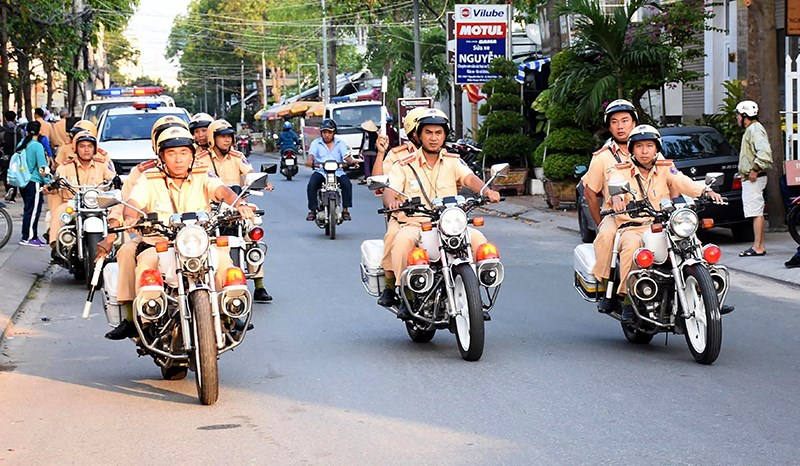

total time taken = 0.30730104446411133 s


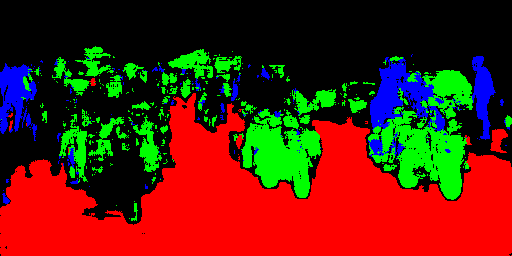

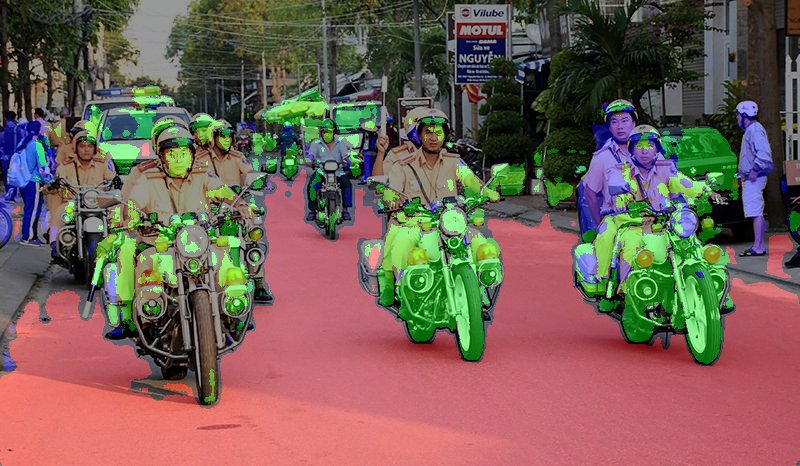

'   0 : Background : None\n      1 : road : Red\n      2 : vehicle : Green\n      3 : human : Blue\n'

In [ ]:
url = "https://previews.123rf.com/images/elenaboronina/elenaboronina1703/elenaboronina170300044/73777664-cars-driving-down-city-street-st-petersburg-buildings-architecture.jpg"
print(f"downloading {url}")
img_sample = io.imread(url)


# x_img_org = cv2.imread("/content/drive/MyDrive/CS_project/CS406/data_semantics/testing/image_2/000010_10.png")
x_img_org1 = cv2.imread("/content/MicrosoftTeams-image.png")

# show_img_demo(img_sample,True) # for image from web
# show_img_demo(x_img_org) # for image from test
show_img_demo(x_img_org1) # for image from test
'''   0 : Background : None
      1 : road : Red
      2 : vehicle : Green
      3 : human : Blue
'''

## By video

In [8]:
import cv2
import time 
import tqdm
vidcap = cv2.VideoCapture("/content/demo_raining.mp4")
success,image = vidcap.read()
count = 0
times = 0
img2video = []
seconds = 10
fps = int(vidcap.get(cv2.CAP_PROP_FPS)) # Gets the frames per second
print("FPS: ",fps)
multiplier = fps * seconds

for i in tqdm.tqdm(range(multiplier)):   
  success,image = vidcap.read()
  result,t = show_img_demo(image, url = False,show = False)
  times += t
  img2video.append(result)
  count += 1

FPS:  30


  0%|          | 0/300 [00:00<?, ?it/s]

total time taken = 10.914464235305786 s


  0%|          | 1/300 [00:13<1:05:36, 13.17s/it]

total time taken = 0.21889019012451172 s


  1%|          | 2/300 [00:15<34:07,  6.87s/it]  

total time taken = 0.2189033031463623 s


  1%|          | 3/300 [00:18<24:06,  4.87s/it]

total time taken = 0.22270655632019043 s


  1%|▏         | 4/300 [00:20<19:26,  3.94s/it]

total time taken = 0.22486042976379395 s


  2%|▏         | 5/300 [00:23<16:47,  3.42s/it]

total time taken = 0.2221059799194336 s


  2%|▏         | 6/300 [00:25<15:09,  3.09s/it]

total time taken = 0.23235845565795898 s


  2%|▏         | 7/300 [00:28<14:09,  2.90s/it]

total time taken = 0.2262876033782959 s


  3%|▎         | 8/300 [00:30<13:31,  2.78s/it]

total time taken = 0.2214975357055664 s


  3%|▎         | 9/300 [00:33<13:00,  2.68s/it]

total time taken = 0.23131465911865234 s


  3%|▎         | 10/300 [00:35<12:39,  2.62s/it]

total time taken = 0.22472047805786133 s


  4%|▎         | 11/300 [00:38<12:25,  2.58s/it]

total time taken = 0.21315360069274902 s


  4%|▍         | 12/300 [00:40<12:12,  2.54s/it]

total time taken = 0.21175265312194824 s


  4%|▍         | 13/300 [00:43<12:07,  2.54s/it]

total time taken = 0.22003626823425293 s


  5%|▍         | 14/300 [00:45<12:01,  2.52s/it]

total time taken = 0.21828532218933105 s


  5%|▌         | 15/300 [00:48<11:59,  2.53s/it]

total time taken = 0.23460912704467773 s


  5%|▌         | 16/300 [00:50<11:56,  2.52s/it]

total time taken = 0.21387743949890137 s


  6%|▌         | 17/300 [00:53<11:54,  2.52s/it]

total time taken = 0.34998011589050293 s


  6%|▌         | 18/300 [00:55<12:01,  2.56s/it]

total time taken = 0.2202918529510498 s


  6%|▋         | 19/300 [00:58<11:52,  2.54s/it]

total time taken = 0.3486061096191406 s


  7%|▋         | 20/300 [01:00<11:58,  2.57s/it]

total time taken = 0.21921110153198242 s


  7%|▋         | 21/300 [01:03<11:54,  2.56s/it]

total time taken = 0.2306842803955078 s


  7%|▋         | 22/300 [01:05<11:48,  2.55s/it]

total time taken = 0.22063541412353516 s


  8%|▊         | 23/300 [01:08<11:43,  2.54s/it]

total time taken = 0.22844839096069336 s


  8%|▊         | 24/300 [01:10<11:40,  2.54s/it]

total time taken = 0.21827149391174316 s


  8%|▊         | 25/300 [01:13<11:38,  2.54s/it]

total time taken = 0.2184751033782959 s


  9%|▊         | 26/300 [01:16<11:32,  2.53s/it]

total time taken = 0.2190084457397461 s


  9%|▉         | 27/300 [01:18<11:25,  2.51s/it]

total time taken = 0.21431422233581543 s


  9%|▉         | 28/300 [01:20<11:21,  2.50s/it]

total time taken = 0.21769237518310547 s


 10%|▉         | 29/300 [01:23<11:17,  2.50s/it]

total time taken = 0.34925246238708496 s


 10%|█         | 30/300 [01:26<11:25,  2.54s/it]

total time taken = 0.22450709342956543 s


 10%|█         | 31/300 [01:28<11:16,  2.52s/it]

total time taken = 0.35239386558532715 s


 11%|█         | 32/300 [01:31<11:23,  2.55s/it]

total time taken = 0.23195385932922363 s


 11%|█         | 33/300 [01:33<11:13,  2.52s/it]

total time taken = 0.2311725616455078 s


 11%|█▏        | 34/300 [01:36<11:11,  2.52s/it]

total time taken = 0.2269744873046875 s


 12%|█▏        | 35/300 [01:38<11:06,  2.52s/it]

total time taken = 0.2238016128540039 s


 12%|█▏        | 36/300 [01:41<11:02,  2.51s/it]

total time taken = 0.23160362243652344 s


 12%|█▏        | 37/300 [01:43<11:00,  2.51s/it]

total time taken = 0.22157931327819824 s


 13%|█▎        | 38/300 [01:46<10:57,  2.51s/it]

total time taken = 0.22078514099121094 s


 13%|█▎        | 39/300 [01:48<10:55,  2.51s/it]

total time taken = 0.2185072898864746 s


 13%|█▎        | 40/300 [01:51<10:50,  2.50s/it]

total time taken = 0.22516846656799316 s


 14%|█▎        | 41/300 [01:53<10:43,  2.49s/it]

total time taken = 0.2226271629333496 s


 14%|█▍        | 42/300 [01:56<10:37,  2.47s/it]

total time taken = 0.21780061721801758 s


 14%|█▍        | 43/300 [01:58<10:34,  2.47s/it]

total time taken = 0.2281630039215088 s


 15%|█▍        | 44/300 [02:00<10:31,  2.47s/it]

total time taken = 0.22133994102478027 s


 15%|█▌        | 45/300 [02:03<10:30,  2.47s/it]

total time taken = 0.22359943389892578 s


 15%|█▌        | 46/300 [02:05<10:28,  2.48s/it]

total time taken = 0.22339534759521484 s


 16%|█▌        | 47/300 [02:08<10:24,  2.47s/it]

total time taken = 0.22301745414733887 s


 16%|█▌        | 48/300 [02:10<10:24,  2.48s/it]

total time taken = 0.3582770824432373 s


 16%|█▋        | 49/300 [02:13<10:30,  2.51s/it]

total time taken = 0.22554397583007812 s


 17%|█▋        | 50/300 [02:15<10:25,  2.50s/it]

total time taken = 0.22768449783325195 s


 17%|█▋        | 51/300 [02:18<10:22,  2.50s/it]

total time taken = 0.35158658027648926 s


 17%|█▋        | 52/300 [02:21<10:27,  2.53s/it]

total time taken = 0.22790884971618652 s


 18%|█▊        | 53/300 [02:23<10:20,  2.51s/it]

total time taken = 0.22543573379516602 s


 18%|█▊        | 54/300 [02:26<10:16,  2.51s/it]

total time taken = 0.22372913360595703 s


 18%|█▊        | 55/300 [02:28<10:11,  2.50s/it]

total time taken = 0.23146533966064453 s


 19%|█▊        | 56/300 [02:31<10:10,  2.50s/it]

total time taken = 0.2321934700012207 s


 19%|█▉        | 57/300 [02:33<10:06,  2.49s/it]

total time taken = 0.23109889030456543 s


 19%|█▉        | 58/300 [02:36<10:04,  2.50s/it]

total time taken = 0.2344350814819336 s


 20%|█▉        | 59/300 [02:38<10:02,  2.50s/it]

total time taken = 0.22985029220581055 s


 20%|██        | 60/300 [02:41<10:01,  2.51s/it]

total time taken = 0.22730779647827148 s


 20%|██        | 61/300 [02:43<09:57,  2.50s/it]

total time taken = 0.2357466220855713 s


 21%|██        | 62/300 [02:46<09:56,  2.51s/it]

total time taken = 0.23511767387390137 s


 21%|██        | 63/300 [02:48<09:52,  2.50s/it]

total time taken = 0.23532700538635254 s


 21%|██▏       | 64/300 [02:51<09:52,  2.51s/it]

total time taken = 0.2262866497039795 s


 22%|██▏       | 65/300 [02:53<09:48,  2.50s/it]

total time taken = 0.23053908348083496 s


 22%|██▏       | 66/300 [02:55<09:40,  2.48s/it]

total time taken = 0.2232058048248291 s


 22%|██▏       | 67/300 [02:58<09:32,  2.45s/it]

total time taken = 0.21851706504821777 s


 23%|██▎       | 68/300 [03:00<09:26,  2.44s/it]

total time taken = 0.21800947189331055 s


 23%|██▎       | 69/300 [03:03<09:20,  2.43s/it]

total time taken = 0.21782708168029785 s


 23%|██▎       | 70/300 [03:05<09:16,  2.42s/it]

total time taken = 0.2231125831604004 s


 24%|██▎       | 71/300 [03:07<09:13,  2.42s/it]

total time taken = 0.2231752872467041 s


 24%|██▍       | 72/300 [03:10<09:13,  2.43s/it]

total time taken = 0.23321771621704102 s


 24%|██▍       | 73/300 [03:12<09:10,  2.43s/it]

total time taken = 0.23056292533874512 s


 25%|██▍       | 74/300 [03:15<09:09,  2.43s/it]

total time taken = 0.22693324089050293 s


 25%|██▌       | 75/300 [03:17<09:06,  2.43s/it]

total time taken = 0.2261183261871338 s


 25%|██▌       | 76/300 [03:20<09:00,  2.41s/it]

total time taken = 0.22792744636535645 s


 26%|██▌       | 77/300 [03:22<08:57,  2.41s/it]

total time taken = 0.22860980033874512 s


 26%|██▌       | 78/300 [03:24<08:54,  2.41s/it]

total time taken = 0.2259669303894043 s


 26%|██▋       | 79/300 [03:27<08:52,  2.41s/it]

total time taken = 0.22578215599060059 s


 27%|██▋       | 80/300 [03:29<08:49,  2.41s/it]

total time taken = 0.22231793403625488 s


 27%|██▋       | 81/300 [03:32<08:45,  2.40s/it]

total time taken = 0.226517915725708 s


 27%|██▋       | 82/300 [03:34<08:41,  2.39s/it]

total time taken = 0.40730834007263184 s


 28%|██▊       | 83/300 [03:37<08:52,  2.45s/it]

total time taken = 0.22254228591918945 s


 28%|██▊       | 84/300 [03:39<08:48,  2.45s/it]

total time taken = 0.23348116874694824 s


 28%|██▊       | 85/300 [03:41<08:43,  2.43s/it]

total time taken = 0.2293863296508789 s


 29%|██▊       | 86/300 [03:44<08:41,  2.44s/it]

total time taken = 0.22510290145874023 s


 29%|██▉       | 87/300 [03:46<08:41,  2.45s/it]

total time taken = 0.21718645095825195 s


 29%|██▉       | 88/300 [03:49<08:37,  2.44s/it]

total time taken = 0.2204575538635254 s


 30%|██▉       | 89/300 [03:51<08:32,  2.43s/it]

total time taken = 0.22983169555664062 s


 30%|███       | 90/300 [03:54<08:29,  2.42s/it]

total time taken = 0.22571444511413574 s


 30%|███       | 91/300 [03:56<08:25,  2.42s/it]

total time taken = 0.21882200241088867 s


 31%|███       | 92/300 [03:58<08:21,  2.41s/it]

total time taken = 0.22124481201171875 s


 31%|███       | 93/300 [04:01<08:17,  2.40s/it]

total time taken = 0.22253966331481934 s


 31%|███▏      | 94/300 [04:03<08:14,  2.40s/it]

total time taken = 0.22164154052734375 s


 32%|███▏      | 95/300 [04:06<08:12,  2.40s/it]

total time taken = 0.21940922737121582 s


 32%|███▏      | 96/300 [04:08<08:09,  2.40s/it]

total time taken = 0.22039008140563965 s


 32%|███▏      | 97/300 [04:10<08:06,  2.40s/it]

total time taken = 0.2170872688293457 s


 33%|███▎      | 98/300 [04:13<08:03,  2.39s/it]

total time taken = 0.22512173652648926 s


 33%|███▎      | 99/300 [04:15<08:04,  2.41s/it]

total time taken = 0.218644380569458 s


 33%|███▎      | 100/300 [04:18<08:05,  2.43s/it]

total time taken = 0.22085356712341309 s


 34%|███▎      | 101/300 [04:20<08:01,  2.42s/it]

total time taken = 0.21907567977905273 s


 34%|███▍      | 102/300 [04:22<07:58,  2.42s/it]

total time taken = 0.21953964233398438 s


 34%|███▍      | 103/300 [04:25<07:53,  2.41s/it]

total time taken = 0.22083258628845215 s


 35%|███▍      | 104/300 [04:27<07:51,  2.41s/it]

total time taken = 0.34929347038269043 s


 35%|███▌      | 105/300 [04:30<07:56,  2.44s/it]

total time taken = 0.2155132293701172 s


 35%|███▌      | 106/300 [04:32<07:49,  2.42s/it]

total time taken = 0.2319643497467041 s


 36%|███▌      | 107/300 [04:35<07:44,  2.40s/it]

total time taken = 0.23313021659851074 s


 36%|███▌      | 108/300 [04:37<07:39,  2.40s/it]

total time taken = 0.24495339393615723 s


 36%|███▋      | 109/300 [04:39<07:40,  2.41s/it]

total time taken = 0.23767733573913574 s


 37%|███▋      | 110/300 [04:42<07:37,  2.41s/it]

total time taken = 0.21910858154296875 s


 37%|███▋      | 111/300 [04:44<07:33,  2.40s/it]

total time taken = 0.222121000289917 s


 37%|███▋      | 112/300 [04:47<07:33,  2.41s/it]

total time taken = 0.22204375267028809 s


 38%|███▊      | 113/300 [04:49<07:32,  2.42s/it]

total time taken = 0.3501467704772949 s


 38%|███▊      | 114/300 [04:52<07:36,  2.45s/it]

total time taken = 0.22344398498535156 s


 38%|███▊      | 115/300 [04:54<07:31,  2.44s/it]

total time taken = 0.22078394889831543 s


 39%|███▊      | 116/300 [04:56<07:26,  2.43s/it]

total time taken = 0.2118823528289795 s


 39%|███▉      | 117/300 [04:59<07:25,  2.43s/it]

total time taken = 0.35386085510253906 s


 39%|███▉      | 118/300 [05:01<07:27,  2.46s/it]

total time taken = 0.22233843803405762 s


 40%|███▉      | 119/300 [05:04<07:21,  2.44s/it]

total time taken = 0.22193479537963867 s


 40%|████      | 120/300 [05:06<07:15,  2.42s/it]

total time taken = 0.22477388381958008 s


 40%|████      | 121/300 [05:08<07:11,  2.41s/it]

total time taken = 0.21465086936950684 s


 41%|████      | 122/300 [05:11<07:08,  2.41s/it]

total time taken = 0.22194743156433105 s


 41%|████      | 123/300 [05:13<07:05,  2.40s/it]

total time taken = 0.23521924018859863 s


 41%|████▏     | 124/300 [05:16<07:03,  2.41s/it]

total time taken = 0.22442102432250977 s


 42%|████▏     | 125/300 [05:18<07:01,  2.41s/it]

total time taken = 0.22510218620300293 s


 42%|████▏     | 126/300 [05:20<06:58,  2.40s/it]

total time taken = 0.21546292304992676 s


 42%|████▏     | 127/300 [05:23<06:57,  2.41s/it]

total time taken = 0.34810900688171387 s


 43%|████▎     | 128/300 [05:25<07:01,  2.45s/it]

total time taken = 0.21879148483276367 s


 43%|████▎     | 129/300 [05:28<06:58,  2.45s/it]

total time taken = 0.2199537754058838 s


 43%|████▎     | 130/300 [05:30<06:54,  2.44s/it]

total time taken = 0.22163701057434082 s


 44%|████▎     | 131/300 [05:33<06:48,  2.42s/it]

total time taken = 0.3553202152252197 s


 44%|████▍     | 132/300 [05:35<06:50,  2.44s/it]

total time taken = 0.22969484329223633 s


 44%|████▍     | 133/300 [05:38<06:46,  2.44s/it]

total time taken = 0.22061824798583984 s


 45%|████▍     | 134/300 [05:40<06:42,  2.43s/it]

total time taken = 0.21675705909729004 s


 45%|████▌     | 135/300 [05:42<06:39,  2.42s/it]

total time taken = 0.34931492805480957 s


 45%|████▌     | 136/300 [05:45<06:41,  2.45s/it]

total time taken = 0.2141561508178711 s


 46%|████▌     | 137/300 [05:47<06:37,  2.44s/it]

total time taken = 0.21814227104187012 s


 46%|████▌     | 138/300 [05:50<06:32,  2.42s/it]

total time taken = 0.22456574440002441 s


 46%|████▋     | 139/300 [05:52<06:28,  2.41s/it]

total time taken = 0.21527910232543945 s


 47%|████▋     | 140/300 [05:54<06:25,  2.41s/it]

total time taken = 0.22641396522521973 s


 47%|████▋     | 141/300 [05:57<06:22,  2.40s/it]

total time taken = 0.22757697105407715 s


 47%|████▋     | 142/300 [05:59<06:20,  2.41s/it]

total time taken = 0.2230548858642578 s


 48%|████▊     | 143/300 [06:02<06:16,  2.40s/it]

total time taken = 0.22420740127563477 s


 48%|████▊     | 144/300 [06:04<06:12,  2.38s/it]

total time taken = 0.22321009635925293 s


 48%|████▊     | 145/300 [06:06<06:09,  2.38s/it]

total time taken = 0.22440838813781738 s


 49%|████▊     | 146/300 [06:09<06:06,  2.38s/it]

total time taken = 0.21859407424926758 s


 49%|████▉     | 147/300 [06:11<06:04,  2.38s/it]

total time taken = 0.22597789764404297 s


 49%|████▉     | 148/300 [06:14<06:02,  2.38s/it]

total time taken = 0.22467398643493652 s


 50%|████▉     | 149/300 [06:16<06:01,  2.39s/it]

total time taken = 0.22993898391723633 s


 50%|█████     | 150/300 [06:18<05:59,  2.39s/it]

total time taken = 0.22841501235961914 s


 50%|█████     | 151/300 [06:21<05:56,  2.39s/it]

total time taken = 0.2202918529510498 s


 51%|█████     | 152/300 [06:23<05:52,  2.38s/it]

total time taken = 0.34989166259765625 s


 51%|█████     | 153/300 [06:26<05:55,  2.42s/it]

total time taken = 0.21948528289794922 s


 51%|█████▏    | 154/300 [06:28<05:51,  2.41s/it]

total time taken = 0.22064638137817383 s


 52%|█████▏    | 155/300 [06:30<05:48,  2.40s/it]

total time taken = 0.23145508766174316 s


 52%|█████▏    | 156/300 [06:33<05:44,  2.40s/it]

total time taken = 0.22751736640930176 s


 52%|█████▏    | 157/300 [06:35<05:41,  2.39s/it]

total time taken = 0.2204728126525879 s


 53%|█████▎    | 158/300 [06:38<05:38,  2.39s/it]

total time taken = 0.21863555908203125 s


 53%|█████▎    | 159/300 [06:40<05:35,  2.38s/it]

total time taken = 0.2242295742034912 s


 53%|█████▎    | 160/300 [06:42<05:33,  2.38s/it]

total time taken = 0.21913504600524902 s


 54%|█████▎    | 161/300 [06:45<05:32,  2.39s/it]

total time taken = 0.22287702560424805 s


 54%|█████▍    | 162/300 [06:47<05:30,  2.39s/it]

total time taken = 0.22000408172607422 s


 54%|█████▍    | 163/300 [06:50<05:28,  2.40s/it]

total time taken = 0.23961830139160156 s


 55%|█████▍    | 164/300 [06:52<05:26,  2.40s/it]

total time taken = 0.2366631031036377 s


 55%|█████▌    | 165/300 [06:54<05:22,  2.39s/it]

total time taken = 0.21349740028381348 s


 55%|█████▌    | 166/300 [06:57<05:20,  2.39s/it]

total time taken = 0.3497292995452881 s


 56%|█████▌    | 167/300 [06:59<05:22,  2.42s/it]

total time taken = 0.22266030311584473 s


 56%|█████▌    | 168/300 [07:02<05:18,  2.41s/it]

total time taken = 0.22142672538757324 s


 56%|█████▋    | 169/300 [07:04<05:14,  2.40s/it]

total time taken = 0.2271709442138672 s


 57%|█████▋    | 170/300 [07:06<05:11,  2.40s/it]

total time taken = 0.22017240524291992 s


 57%|█████▋    | 171/300 [07:09<05:08,  2.39s/it]

total time taken = 0.21965241432189941 s


 57%|█████▋    | 172/300 [07:11<05:04,  2.38s/it]

total time taken = 0.21430468559265137 s


 58%|█████▊    | 173/300 [07:13<05:02,  2.38s/it]

total time taken = 0.3635265827178955 s


 58%|█████▊    | 174/300 [07:16<05:06,  2.43s/it]

total time taken = 0.21337175369262695 s


 58%|█████▊    | 175/300 [07:18<05:01,  2.41s/it]

total time taken = 0.2251582145690918 s


 59%|█████▊    | 176/300 [07:21<04:57,  2.40s/it]

total time taken = 0.21767759323120117 s


 59%|█████▉    | 177/300 [07:23<04:53,  2.39s/it]

total time taken = 0.21730613708496094 s


 59%|█████▉    | 178/300 [07:25<04:51,  2.39s/it]

total time taken = 0.2203676700592041 s


 60%|█████▉    | 179/300 [07:28<04:49,  2.39s/it]

total time taken = 0.22578120231628418 s


 60%|██████    | 180/300 [07:30<04:46,  2.39s/it]

total time taken = 0.2282087802886963 s


 60%|██████    | 181/300 [07:33<04:44,  2.39s/it]

total time taken = 0.2299494743347168 s


 61%|██████    | 182/300 [07:35<04:42,  2.40s/it]

total time taken = 0.21657824516296387 s


 61%|██████    | 183/300 [07:37<04:41,  2.40s/it]

total time taken = 0.22004175186157227 s


 61%|██████▏   | 184/300 [07:40<04:37,  2.39s/it]

total time taken = 0.22043800354003906 s


 62%|██████▏   | 185/300 [07:42<04:34,  2.39s/it]

total time taken = 0.2209000587463379 s


 62%|██████▏   | 186/300 [07:45<04:32,  2.39s/it]

total time taken = 0.22178316116333008 s


 62%|██████▏   | 187/300 [07:47<04:30,  2.39s/it]

total time taken = 0.2241804599761963 s


 63%|██████▎   | 188/300 [07:49<04:27,  2.39s/it]

total time taken = 0.2217729091644287 s


 63%|██████▎   | 189/300 [07:52<04:26,  2.40s/it]

total time taken = 0.23152518272399902 s


 63%|██████▎   | 190/300 [07:54<04:22,  2.39s/it]

total time taken = 0.21996331214904785 s


 64%|██████▎   | 191/300 [07:57<04:20,  2.39s/it]

total time taken = 0.22006464004516602 s


 64%|██████▍   | 192/300 [07:59<04:17,  2.39s/it]

total time taken = 0.22299718856811523 s


 64%|██████▍   | 193/300 [08:01<04:15,  2.39s/it]

total time taken = 0.22429156303405762 s


 65%|██████▍   | 194/300 [08:04<04:12,  2.39s/it]

total time taken = 0.22389960289001465 s


 65%|██████▌   | 195/300 [08:06<04:10,  2.38s/it]

total time taken = 0.21369051933288574 s


 65%|██████▌   | 196/300 [08:08<04:07,  2.38s/it]

total time taken = 0.23378586769104004 s


 66%|██████▌   | 197/300 [08:11<04:05,  2.39s/it]

total time taken = 0.35626673698425293 s


 66%|██████▌   | 198/300 [08:13<04:06,  2.42s/it]

total time taken = 0.3527030944824219 s


 66%|██████▋   | 199/300 [08:16<04:07,  2.45s/it]

total time taken = 0.2162637710571289 s


 67%|██████▋   | 200/300 [08:18<04:02,  2.43s/it]

total time taken = 0.22182059288024902 s


 67%|██████▋   | 201/300 [08:21<03:58,  2.41s/it]

total time taken = 0.21842551231384277 s


 67%|██████▋   | 202/300 [08:23<03:55,  2.40s/it]

total time taken = 0.2164289951324463 s


 68%|██████▊   | 203/300 [08:25<03:51,  2.39s/it]

total time taken = 0.22552728652954102 s


 68%|██████▊   | 204/300 [08:28<03:49,  2.39s/it]

total time taken = 0.21916699409484863 s


 68%|██████▊   | 205/300 [08:30<03:46,  2.38s/it]

total time taken = 0.2182445526123047 s


 69%|██████▊   | 206/300 [08:33<03:43,  2.38s/it]

total time taken = 0.2260432243347168 s


 69%|██████▉   | 207/300 [08:35<03:40,  2.37s/it]

total time taken = 0.23032784461975098 s


 69%|██████▉   | 208/300 [08:37<03:37,  2.37s/it]

total time taken = 0.23324823379516602 s


 70%|██████▉   | 209/300 [08:40<03:35,  2.37s/it]

total time taken = 0.22807741165161133 s


 70%|███████   | 210/300 [08:42<03:33,  2.38s/it]

total time taken = 0.22885513305664062 s


 70%|███████   | 211/300 [08:44<03:32,  2.39s/it]

total time taken = 0.22209858894348145 s


 71%|███████   | 212/300 [08:47<03:30,  2.39s/it]

total time taken = 0.22097134590148926 s


 71%|███████   | 213/300 [08:49<03:26,  2.38s/it]

total time taken = 0.35130786895751953 s


 71%|███████▏  | 214/300 [08:52<03:27,  2.41s/it]

total time taken = 0.2339341640472412 s


 72%|███████▏  | 215/300 [08:54<03:23,  2.40s/it]

total time taken = 0.22807526588439941 s


 72%|███████▏  | 216/300 [08:56<03:21,  2.39s/it]

total time taken = 0.21745657920837402 s


 72%|███████▏  | 217/300 [08:59<03:17,  2.39s/it]

total time taken = 0.22038722038269043 s


 73%|███████▎  | 218/300 [09:01<03:15,  2.38s/it]

total time taken = 0.22084879875183105 s


 73%|███████▎  | 219/300 [09:03<03:12,  2.38s/it]

total time taken = 0.22014737129211426 s


 73%|███████▎  | 220/300 [09:06<03:10,  2.38s/it]

total time taken = 0.21964693069458008 s


 74%|███████▎  | 221/300 [09:08<03:07,  2.37s/it]

total time taken = 0.21498656272888184 s


 74%|███████▍  | 222/300 [09:11<03:04,  2.37s/it]

total time taken = 0.23171067237854004 s


 74%|███████▍  | 223/300 [09:13<03:02,  2.36s/it]

total time taken = 0.21799087524414062 s


 75%|███████▍  | 224/300 [09:15<03:00,  2.37s/it]

total time taken = 0.22840023040771484 s


 75%|███████▌  | 225/300 [09:18<02:58,  2.38s/it]

total time taken = 0.22558355331420898 s


 75%|███████▌  | 226/300 [09:20<02:55,  2.37s/it]

total time taken = 0.2177436351776123 s


 76%|███████▌  | 227/300 [09:22<02:53,  2.37s/it]

total time taken = 0.21828866004943848 s


 76%|███████▌  | 228/300 [09:25<02:51,  2.38s/it]

total time taken = 0.3481943607330322 s


 76%|███████▋  | 229/300 [09:27<02:51,  2.42s/it]

total time taken = 0.21805882453918457 s


 77%|███████▋  | 230/300 [09:30<02:48,  2.41s/it]

total time taken = 0.2268383502960205 s


 77%|███████▋  | 231/300 [09:32<02:45,  2.39s/it]

total time taken = 0.22046208381652832 s


 77%|███████▋  | 232/300 [09:34<02:42,  2.39s/it]

total time taken = 0.2189617156982422 s


 78%|███████▊  | 233/300 [09:37<02:39,  2.38s/it]

total time taken = 0.22397065162658691 s


 78%|███████▊  | 234/300 [09:39<02:36,  2.37s/it]

total time taken = 0.3596794605255127 s


 78%|███████▊  | 235/300 [09:42<02:36,  2.41s/it]

total time taken = 0.22460389137268066 s


 79%|███████▊  | 236/300 [09:44<02:33,  2.40s/it]

total time taken = 0.2251739501953125 s


 79%|███████▉  | 237/300 [09:47<02:32,  2.42s/it]

total time taken = 0.21628928184509277 s


 79%|███████▉  | 238/300 [09:49<02:29,  2.41s/it]

total time taken = 0.22671818733215332 s


 80%|███████▉  | 239/300 [09:51<02:27,  2.41s/it]

total time taken = 0.21715307235717773 s


 80%|████████  | 240/300 [09:54<02:24,  2.40s/it]

total time taken = 0.22310328483581543 s


 80%|████████  | 241/300 [09:56<02:21,  2.40s/it]

total time taken = 0.22431039810180664 s


 81%|████████  | 242/300 [09:58<02:18,  2.39s/it]

total time taken = 0.22023415565490723 s


 81%|████████  | 243/300 [10:01<02:16,  2.39s/it]

total time taken = 0.2246382236480713 s


 81%|████████▏ | 244/300 [10:03<02:13,  2.39s/it]

total time taken = 0.22066974639892578 s


 82%|████████▏ | 245/300 [10:06<02:11,  2.38s/it]

total time taken = 0.22061657905578613 s


 82%|████████▏ | 246/300 [10:08<02:08,  2.38s/it]

total time taken = 0.22882461547851562 s


 82%|████████▏ | 247/300 [10:10<02:06,  2.38s/it]

total time taken = 0.22046184539794922 s


 83%|████████▎ | 248/300 [10:13<02:03,  2.37s/it]

total time taken = 0.21383380889892578 s


 83%|████████▎ | 249/300 [10:15<02:01,  2.38s/it]

total time taken = 0.21976494789123535 s


 83%|████████▎ | 250/300 [10:18<01:59,  2.39s/it]

total time taken = 0.2224104404449463 s


 84%|████████▎ | 251/300 [10:20<01:57,  2.40s/it]

total time taken = 0.22333502769470215 s


 84%|████████▍ | 252/300 [10:22<01:54,  2.40s/it]

total time taken = 0.21871733665466309 s


 84%|████████▍ | 253/300 [10:25<01:52,  2.39s/it]

total time taken = 0.2248537540435791 s


 85%|████████▍ | 254/300 [10:27<01:50,  2.39s/it]

total time taken = 0.2240738868713379 s


 85%|████████▌ | 255/300 [10:30<01:47,  2.38s/it]

total time taken = 0.22306442260742188 s


 85%|████████▌ | 256/300 [10:32<01:44,  2.37s/it]

total time taken = 0.21897077560424805 s


 86%|████████▌ | 257/300 [10:34<01:41,  2.36s/it]

total time taken = 0.22380971908569336 s


 86%|████████▌ | 258/300 [10:37<01:39,  2.36s/it]

total time taken = 0.22045207023620605 s


 86%|████████▋ | 259/300 [10:39<01:36,  2.36s/it]

total time taken = 0.21877670288085938 s


 87%|████████▋ | 260/300 [10:41<01:34,  2.37s/it]

total time taken = 0.24151253700256348 s


 87%|████████▋ | 261/300 [10:44<01:32,  2.37s/it]

total time taken = 0.23008370399475098 s


 87%|████████▋ | 262/300 [10:46<01:30,  2.37s/it]

total time taken = 0.23032355308532715 s


 88%|████████▊ | 263/300 [10:48<01:28,  2.39s/it]

total time taken = 0.22159218788146973 s


 88%|████████▊ | 264/300 [10:51<01:26,  2.39s/it]

total time taken = 0.22552728652954102 s


 88%|████████▊ | 265/300 [10:53<01:23,  2.39s/it]

total time taken = 0.2244584560394287 s


 89%|████████▊ | 266/300 [10:56<01:21,  2.39s/it]

total time taken = 0.35143399238586426 s


 89%|████████▉ | 267/300 [10:58<01:19,  2.42s/it]

total time taken = 0.21427249908447266 s


 89%|████████▉ | 268/300 [11:01<01:16,  2.40s/it]

total time taken = 0.21773195266723633 s


 90%|████████▉ | 269/300 [11:03<01:14,  2.39s/it]

total time taken = 0.21705055236816406 s


 90%|█████████ | 270/300 [11:05<01:11,  2.38s/it]

total time taken = 0.21619439125061035 s


 90%|█████████ | 271/300 [11:08<01:08,  2.38s/it]

total time taken = 0.22700786590576172 s


 91%|█████████ | 272/300 [11:10<01:06,  2.36s/it]

total time taken = 0.21858763694763184 s


 91%|█████████ | 273/300 [11:12<01:03,  2.36s/it]

total time taken = 0.21361279487609863 s


 91%|█████████▏| 274/300 [11:15<01:01,  2.37s/it]

total time taken = 0.22520709037780762 s


 92%|█████████▏| 275/300 [11:17<00:59,  2.36s/it]

total time taken = 0.22485947608947754 s


 92%|█████████▏| 276/300 [11:19<00:57,  2.38s/it]

total time taken = 0.22797775268554688 s


 92%|█████████▏| 277/300 [11:22<00:54,  2.37s/it]

total time taken = 0.22089791297912598 s


 93%|█████████▎| 278/300 [11:24<00:51,  2.36s/it]

total time taken = 0.22740435600280762 s


 93%|█████████▎| 279/300 [11:27<00:50,  2.39s/it]

total time taken = 0.22768926620483398 s


 93%|█████████▎| 280/300 [11:29<00:47,  2.38s/it]

total time taken = 0.2307119369506836 s


 94%|█████████▎| 281/300 [11:31<00:45,  2.38s/it]

total time taken = 0.23095297813415527 s


 94%|█████████▍| 282/300 [11:34<00:42,  2.38s/it]

total time taken = 0.22389483451843262 s


 94%|█████████▍| 283/300 [11:36<00:40,  2.38s/it]

total time taken = 0.35547780990600586 s


 95%|█████████▍| 284/300 [11:39<00:38,  2.41s/it]

total time taken = 0.2183222770690918 s


 95%|█████████▌| 285/300 [11:41<00:35,  2.39s/it]

total time taken = 0.21985483169555664 s


 95%|█████████▌| 286/300 [11:43<00:33,  2.38s/it]

total time taken = 0.21643877029418945 s


 96%|█████████▌| 287/300 [11:46<00:30,  2.37s/it]

total time taken = 0.22238993644714355 s


 96%|█████████▌| 288/300 [11:48<00:28,  2.38s/it]

total time taken = 0.21879148483276367 s


 96%|█████████▋| 289/300 [11:50<00:26,  2.39s/it]

total time taken = 0.22556638717651367 s


 97%|█████████▋| 290/300 [11:53<00:23,  2.39s/it]

total time taken = 0.22728657722473145 s


 97%|█████████▋| 291/300 [11:55<00:21,  2.38s/it]

total time taken = 0.21856260299682617 s


 97%|█████████▋| 292/300 [11:58<00:18,  2.37s/it]

total time taken = 0.22050952911376953 s


 98%|█████████▊| 293/300 [12:00<00:16,  2.38s/it]

total time taken = 0.35503602027893066 s


 98%|█████████▊| 294/300 [12:02<00:14,  2.42s/it]

total time taken = 0.21299338340759277 s


 98%|█████████▊| 295/300 [12:05<00:12,  2.41s/it]

total time taken = 0.22098159790039062 s


 99%|█████████▊| 296/300 [12:07<00:09,  2.39s/it]

total time taken = 0.21279358863830566 s


 99%|█████████▉| 297/300 [12:10<00:07,  2.39s/it]

total time taken = 0.2303767204284668 s


 99%|█████████▉| 298/300 [12:12<00:04,  2.38s/it]

total time taken = 0.221771240234375 s


100%|█████████▉| 299/300 [12:14<00:02,  2.37s/it]

total time taken = 0.22409582138061523 s


100%|██████████| 300/300 [12:17<00:00,  2.46s/it]


In [10]:

print(f"Total: {count} frame \nTotal processing time is: {times} s, average: {times/fps}s per frame ")

out = cv2.VideoWriter('video_test_1.mp4',cv2.VideoWriter_fourcc(*'DIVX'), fps, (image.shape[1], image.shape[0]))

for i in range(len(img2video)):
    out.write(img2video[i])
out.release()
print("Video made successfully")

Total: 300 frame 
Total processing time is: 80.83625388145447 s, average: 2.6945417960484823s per frame 
Video made successfully
